# Fitting the data to a Supported Vector Regression model

We will fit a model with the non-cumulative data and another with the cumulative data. This is because fitting both simultaneously can have an impact in the fit: the accumulated data can be "contradictory" with the non-cumulative.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
data = pd.read_csv('../ML_models/data_for_ML.csv').drop('Unnamed: 0',axis=1)

In [3]:
data.head()

,year,week,geoId,cases_per_100khab,cmltve_cases,first_dose_100k,cmltve_first_dose,second_dose_100k,cmltve_second_dose,deaths_per_100khab,cmltve_deaths
0,2020,0,AT,6.628421,12.886100,0.0,0.0,0.0,0.0,0.157285,0.280865
1,2020,1,AT,108.604994,242.139591,0.0,0.0,0.0,0.0,1.808773,3.505199
2,2020,5,AT,11.976096,847.932337,0.0,0.0,0.0,0.0,0.258396,15.245368
3,2020,6,AT,109.829566,572.571998,0.0,0.0,0.0,0.0,1.797538,9.010159
4,2020,8,AT,0.089877,948.369768,0.0,0.0,0.0,0.0,0.000000,16.087964


In [4]:
data['year']=data['year'].astype(str)
data['week']=data['week'].astype(str)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3667 entries, 0 to 3666
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                3667 non-null   object 
 1   week                3667 non-null   object 
 2   geoId               3667 non-null   object 
 3   cases_per_100khab   3667 non-null   float64
 4   cmltve_cases        3667 non-null   float64
 5   first_dose_100k     3667 non-null   float64
 6   cmltve_first_dose   3667 non-null   float64
 7   second_dose_100k    3667 non-null   float64
 8   cmltve_second_dose  3667 non-null   float64
 9   deaths_per_100khab  3667 non-null   float64
 10  cmltve_deaths       3667 non-null   float64
dtypes: float64(8), object(3)
memory usage: 315.3+ KB


## Accumulated data (data_new)

In [6]:
ncd=['year','week','geoId','cmltve_cases','cmltve_first_dose','cmltve_second_dose','cmltve_deaths']
data_accum=data[ncd]

## EDA

### Numericals

In [7]:
data_accum.describe().round(2)

,cmltve_cases,cmltve_first_dose,cmltve_second_dose,cmltve_deaths
count,3667.00,3667.00,3667.00,3667.00
mean,38174.69,55732.38,44164.12,573.59
std,37876.17,82588.96,70563.97,576.33
min,1.03,0.00,0.00,0.00
25%,6389.79,0.00,0.00,104.70
50%,27489.87,0.00,0.00,369.06
75%,60523.16,111838.54,82904.54,908.09
max,254683.59,484564.58,459515.99,3399.19


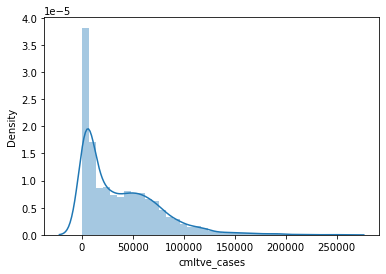

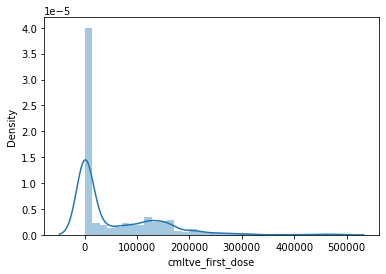

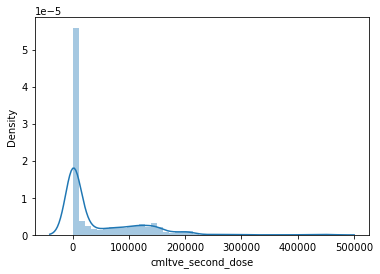

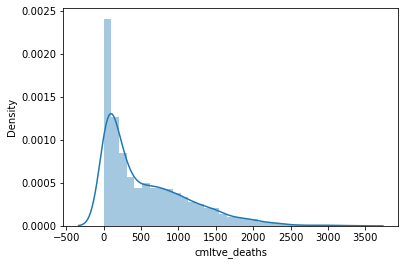

In [8]:
for column in data_accum.select_dtypes(np.number).columns:
    sns.distplot(data_accum[column])
    plt.show()

### Categoricals

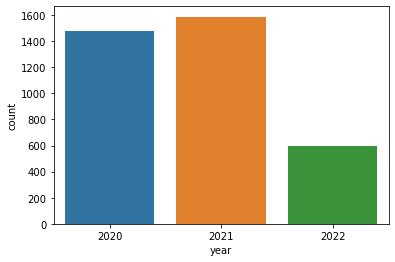

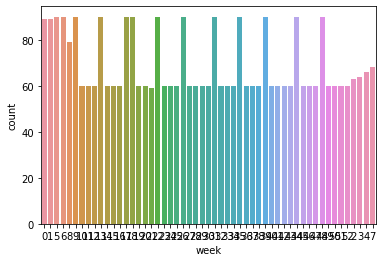

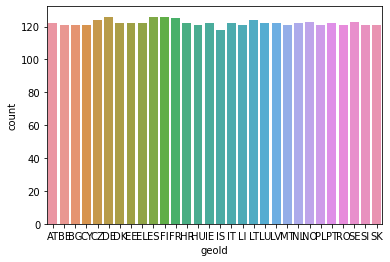

In [9]:
for col in data_accum.select_dtypes(np.object).columns:
    sns.countplot(x=data_accum[col]) #, hue=df['education']
    plt.show()

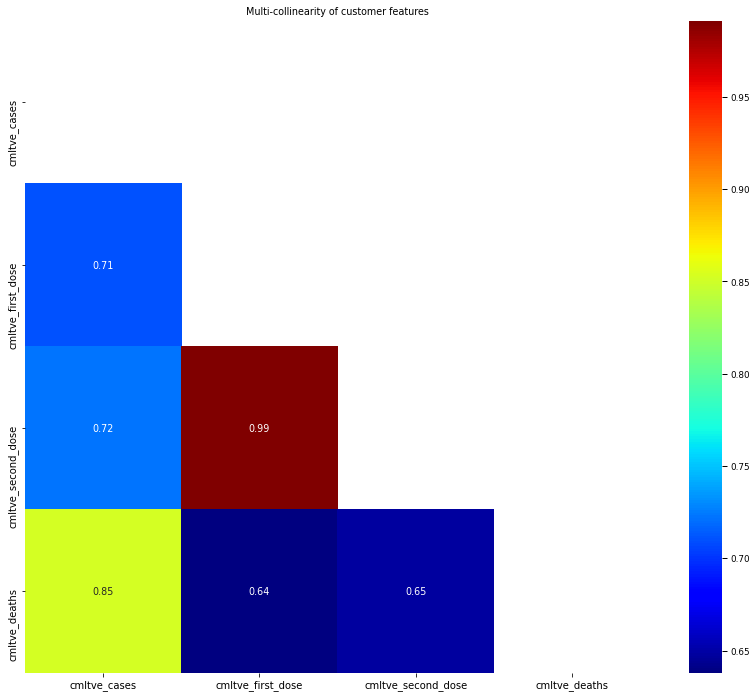

In [10]:
# Correlation matrix
corr_mat = data_accum.corr(method='spearman')
mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True # Mask to hide the repeated half of the matrix

fig, ax = plt.subplots(figsize=(14, 12)) # this will set the width and height of the plot
sns.set_context('paper') #This affects things like the size of the labels, lines, and other elements of the plot
ax = sns.heatmap(corr_mat, mask=mask, annot=True, cmap='jet') # Heatmap declaration
ax.set_title('Multi-collinearity of customer features') #Title for the graph
plt.show()

In [11]:
data_accum.drop('cmltve_second_dose', axis=1, inplace=True)

## Preprocessing

In [12]:
# X-y Split
y = data_accum['cmltve_deaths']
X = data_accum.drop(['cmltve_deaths'], axis=1)
X.columns

Index(['year', 'week', 'geoId', 'cmltve_cases', 'cmltve_first_dose'], dtype='object')

In [13]:
# Separate numerical and categorical values
X_num = X.select_dtypes(include='number')
X_cat = X.select_dtypes(exclude='number')

In [14]:
# One Hot Encoding categorical variables

encoder = OneHotEncoder(handle_unknown='error', drop='first') #drop one column for efficiency. It can be deduced
X_cat_encoded = encoder.fit_transform(X_cat).toarray()
X_cat_encoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.]])

In [15]:
# Concat DataFrames

column_names = list(X_num.columns) # get list of numerical column names
column_names.extend(list(encoder.get_feature_names())) # add list of dummified categorical column names

X_numcat = np.concatenate([X_num, X_cat_encoded], axis=1)
X_ready = pd.DataFrame(data=X_numcat, index=X.index, columns=column_names)
X_ready.sample(5)

,cmltve_cases,cmltve_first_dose,x0_2021,x0_2022,x1_1,x1_10,x1_11,x1_12,x1_13,x1_14,x1_15,x1_16,x1_17,x1_18,x1_19,x1_2,x1_20,x1_21,x1_22,x1_23,x1_24,x1_25,x1_26,x1_27,x1_28,x1_29,x1_3,x1_30,x1_31,x1_32,x1_33,x1_34,x1_35,x1_36,x1_37,x1_38,x1_39,x1_4,x1_40,x1_41,x1_42,x1_43,x1_44,x1_45,x1_46,x1_47,x1_48,x1_49,x1_5,x1_50,x1_51,x1_52,x1_6,x1_7,x1_8,x1_9,x2_BE,x2_BG,x2_CY,x2_CZ,x2_DE,x2_DK,x2_EE,x2_EL,x2_ES,x2_FI,x2_FR,x2_HR,x2_HU,x2_IE,x2_IS,x2_IT,x2_LI,x2_LT,x2_LU,x2_LV,x2_MT,x2_NL,x2_NO,x2_PL,x2_PT,x2_RO,x2_SE,x2_SI,x2_SK
3421,45806.673755,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1820,90436.323130,163627.760634,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2918,15351.368773,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2238,8365.120665,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2855,3169.417130,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_ready, y, test_size=0.3, random_state=42)

### Model fitting

In [17]:
scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform (X_test)
scaler_y = StandardScaler().fit(y_train.to_numpy().reshape(-1, 1))

In [18]:
model = LinearSVR(random_state=42, tol=1e-5)
model.fit(X_train, y_train)

LinearSVR(random_state=42, tol=1e-05)

## Evaluation

In [19]:
predictions_norm = model.predict(X_test)
R2 = r2_score(y_test, predictions_norm)

predictions = scaler_y.inverse_transform(predictions_norm.reshape(-1, 1))

MAE = mean_absolute_error(y_test, predictions)
MSE = mean_squared_error(y_test, predictions, squared=True)
RMSE = mean_squared_error(y_test, predictions, squared=False)

print('R2 =',R2, 'MAE =', MAE, 'MSE =', MSE, 'RMSE =', RMSE)

R2 = 0.7423989277313796 MAE = 307218.4103160071 MSE = 145746991927.58334 RMSE = 381768.2437390299


In [20]:
#Scaled metrics for comparison

y_test_scaled = scaler_y.transform (y_test.to_numpy().reshape(-1, 1))

MAE_s = mean_absolute_error(y_test_scaled, predictions_norm)
MSE_s = mean_squared_error(y_test_scaled, predictions_norm, squared=True)
RMSE_s = mean_squared_error(y_test_scaled, predictions_norm, squared=False)

In [24]:
metrics={'model':['SVR_accum'],'score':[R2],'mean_absolute_error':[MAE],'mean_squared_error':[MSE], 'RMSE':[RMSE]}
#metrics_df=pd.DataFrame(metrics)
metrics_df=pd.DataFrame(metrics)
display(metrics_df)
metrics_df.to_csv('../Streamlit/SVR_accum_metrics.csv')

,model,score,mean_absolute_error,mean_squared_error,RMSE
0,SVR_accum,0.742399,307218.410316,1.457470e+11,381768.243739


,true,pred,resid
221,1712.614689,1.050177e+06,1.048465e+06
220,1697.808797,1.025880e+06,1.024182e+06
219,1683.888135,1.000915e+06,9.992313e+05
3523,1822.639956,9.912025e+05,9.893799e+05
3655,2292.376536,9.881511e+05,9.858587e+05
...,...,...,...
2582,28.567875,-2.270541e+03,2.299109e+03
1731,40.326804,-1.797932e+03,1.838259e+03
1732,63.511695,1.630922e+03,1.567410e+03
2589,32.065982,-9.470251e+02,9.790911e+02


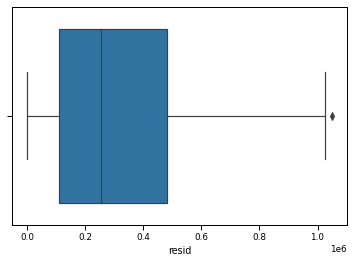

In [22]:
import math

results = pd.DataFrame()
results['true'] = y_test
results['pred'] = predictions
results['resid'] = results.apply(lambda x: abs(x['true'] - x['pred']), axis=1)
results=results.sort_values('resid', ascending=False)

results.to_csv('../Streamlit/SVR_accum_results.csv')

display(results)
sns.boxplot(x=results['resid'])
plt.show()

<AxesSubplot:xlabel='true', ylabel='pred'>

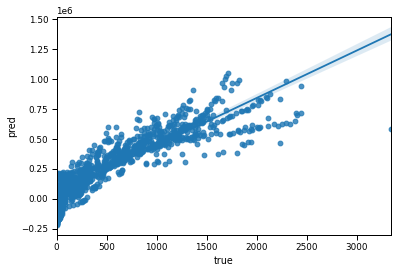

In [23]:
sns.regplot(results['true'], results['pred'])